# My first magma ocean
Let's get started with MOAI and implement our first magma ocean!

## Create a magma ocean
We need to specify a few parameters when creating a magma ocean object:
 - the potential temperature
 - the CMB pressure
 - the equations of state   
 
An there are a few other optional parameters (like the planetary radius and gravity) than can also be passed as keyword arguments. The native radial coordinate is pressure. The magma ocean has a built-in solver for lithostatic equilibrium, that calculates the radii/depths based on the pressure and the equations of state. While this is done during the initialization of the MO object, it is not automatically called every time we update it subsequently. For the sake of simplicity, we consider that the pressure/depth relationship does not evolve (which is not the case if the equations of state are temperature-dependent). If you really want, you can enforce it, but it needs a bit of tweaking MOAI and is for more advanced users.

Text(0, 0.5, 'pressure [GPa]')

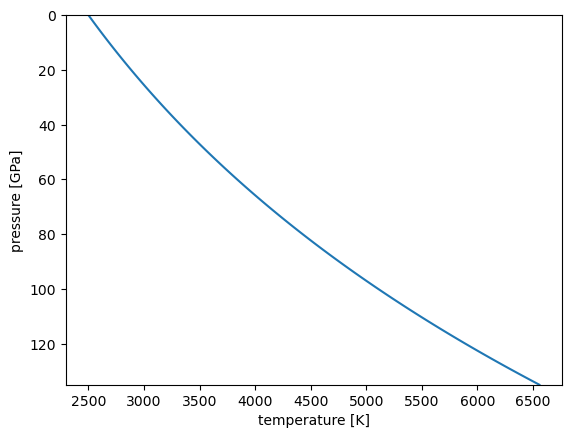

In [3]:
from magma_ocean import magma_ocean
from physics.constants import Earth_gravity,Earth_surface_radius

# define MO potential temperature and mantle depth
T_pot = 2500. # [K]
p_CMB = 135e9 # [Pa]

# create "constant" equations of state
rho   = lambda p,T: 3500. # [kg/m³]
alpha = lambda p,T: 3e-5  # [K⁻¹]
cp    = lambda p,T: 1200. # [J/K/kg]

# create magma ocean object
basic_MO = magma_ocean(T_pot,
                       p_CMB,
                       eos={'rho':rho,'alpha':alpha,'cp':cp},
                       g=Earth_gravity,
                       R=Earth_surface_radius,
                       ConvCum=True)

# plot
import matplotlib.pyplot as plt
plt.plot(basic_MO.profiles['temperatures'],basic_MO.profiles['pressures']*1e-9)
plt.ylim(135,0)
plt.xlabel('temperature [K]')
plt.ylabel('pressure [GPa]')

We just plotted the temperature profile through our magma ocean. It follows an adiabat, given by the equation:
$$\frac{dT}{dp}=\frac{\alpha T}{\rho c_p}$$
where $T$ is the tempature, $p$ the pressure, $\alpha$ the thermal expansivity, $\rho$ the density and $c_p$ the heat capacity. This equation is integrated given the boundary condition $T(p=p_{\rm sfc})=T_{\rm pot}$. In general we can consider $p_{\rm sfc}=0$ Pa, since any variation below $\sim100$ MPa will not affect the adiabt significantly.    
Thats great, but the adiabatic temperature increase is actually a bit too high. And the curvature is strange as well... This is because we have used way too simple equations of state (we have simply considered $\alpha$, $\rho$ and $c_p$ constant!

## Use better equations of state
For silicate melt, we can use the following expression, derived by Abe 1997, from a Murnaghan equation of state and a $T$-independent Grüneisen parameter
$$\alpha(p)=\alpha_0\left(\frac{K'}{K_0}-1\right)^{-\frac{m-1+K'}{K'}}$$
For density, a simple linear function of pressure, fitted from Myiazaki and Korenaga 2019 will do. Finally, $c_p$ can stay constant. All these functions are already included in MOAI, in the eos subpackage. If you are really picky about equations of state, you can check he chapter on how to use burnman to have much better ones.

Text(0, 0.5, 'pressure [GPa]')

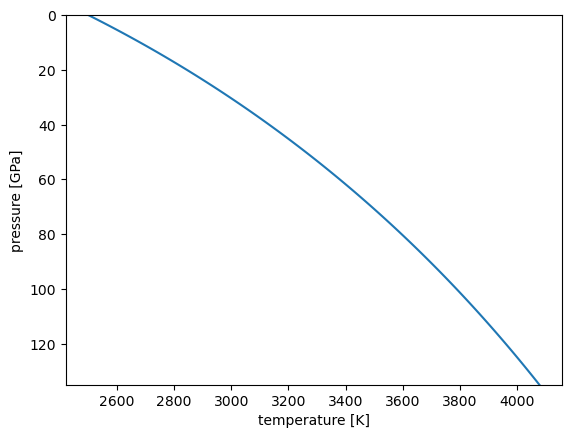

In [5]:
from physics.eos import *
better_MO = magma_ocean(T_pot,
                        p_CMB,
                        eos={'rho':eos_book['rho']['MK19l'],'alpha':eos_book['alpha']['N19'],'cp':cp},
                        g=Earth_gravity,
                        R=Earth_surface_radius,
                        ConvCum=True)
# plot
plt.plot(better_MO.profiles['temperatures'],better_MO.profiles['pressures']*1e-9)
plt.ylim(135,0)
plt.xlabel('temperature [K]')
plt.ylabel('pressure [GPa]')

That's a much nicer adiabat! But actually, we don't really expect silicate at 4000 K and 120 GPa to be molten. Let's now gear our magma ocean with melting curves:

## Add melting curves
You can chose your favorite set of melting curves from the catalog in the phase_change.refractories subpackage, or implement your own (using the melting_curves class). When adding melting curves to a magma ocean, you also need to give the RCMF (rheologically critical melt fraction), which is the melt fraction at below which the magma ocean becomes the solid cumulates. By assumption, the melt fraction ($\phi$) evolves linearly with temperature between the liquids (where $\phi=1$) and the solidus (where $\phi=0$). The bottom of the magma ocean will be somewhere in between, where $\phi=\phi_{\rm RCMF}$. Here we consider $\phi_{\rm RCMF}=0.4$

No file found: calculating lookups, be patient it can take some time!


Text(0.5, 0, 'melt fraction')

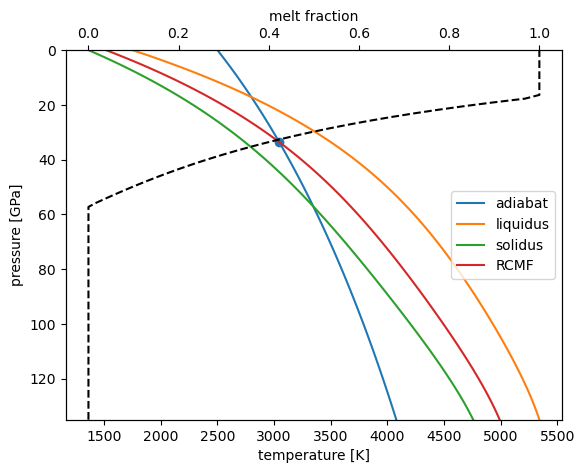

In [17]:
from physics.phase_change.refractories import mc_book
mc = mc_book['Earth'] # melting curves from Fiquet et al., 2010
better_MO.setMeltingCurves(mc,RCMF=0.4)

# adiabat
plt.plot(better_MO.profiles['temperatures'],better_MO.profiles['pressures']*1e-9,label='adiabat')

# melting curves
plt.plot(mc.liquidus,mc.p_lookup*1e-9,label='liquidus')
plt.plot(mc.solidus,mc.p_lookup*1e-9,label='solidus')
plt.plot(mc.solidus*(1-better_MO.mc.RCMF)+better_MO.mc.RCMF*mc.liquidus,mc.p_lookup*1e-9,label='RCMF')

# MO bottom
plt.scatter([better_MO.adiabat.getT(better_MO.p_bot)],[better_MO.p_bot*1e-9])

plt.legend(loc=7)
plt.ylim(135,0)
plt.xlabel('temperature [K]')
plt.ylabel('pressure [GPa]')

plt.twiny()
plt.plot(better_MO.profiles['phi'],better_MO.profiles['pressures']*1e-9,'k--')
plt.xlabel('melt fraction')

The bottom of the magma ocean (materialized by the blue marker) lies at about 35 GPa, where the adiabat intercepts the RCMF. That's also (by definition) where the melt fraction (black dashed line, read off the top $x$-axis) reaches the RCMF value of 0.4.